In [925]:
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss, KLDivLoss
from torch.optim import SGD, RMSprop, Adam, AdamW
import matplotlib.pyplot as plt
from torch.serialization import add_safe_globals
from homework_model import NN
# 添加模型定义到 torch.serialization.safe_globals()
add_safe_globals([nn.Linear])

In [926]:
# 设备选择
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 数据集加载
olivetti_faces_data = fetch_olivetti_faces(data_home='./scikit_learn_data/fetch_olivetti_faces',
                                            shuffle=True, download_if_missing=True, return_X_y=False)

In [927]:
# 超参数定义
lr = 1e-3
epochs = 400
batc_size = 80

In [928]:
# 数据预处理——拆分数据集,但是暂时没有想到怎么使用
train_olivetti_faces_data, test_olivetti_faces_data, train_olivetti_faces_target, test_olivetti_faces_target = \
    train_test_split(olivetti_faces_data.data, olivetti_faces_data.target, test_size=0.3, shuffle=True)

In [929]:
# 数据预处理,构造一个（images,target）tuple
images = torch.tensor(olivetti_faces_data.data)
targets = torch.tensor(olivetti_faces_data.target).long()
# （images,target）tuple    转换为（（images,target））list
datasets = [(image, target) for image, target in zip(images, targets)]  # olivetti_faces_data = list(zip(images, target))
# 构造一个DataLoader对象，用于批量加载数据
train_dl= DataLoader(datasets, batch_size=batc_size, shuffle=True)

In [930]:
# 网络模型构建
models = [NN().to(device) for _ in range(3)]
# print(models)

In [931]:
# 损失函数和优化器定义
loss_fn = CrossEntropyLoss()# 交叉熵损失函数

SGD_optimizer = SGD(models[0].parameters(), lr=lr)                      #momentum=0, dampening=0, weight_decay=0, nesterov=False)
AdamW_optimizer = AdamW(models[1].parameters(), lr=lr)

In [932]:
# 模型训练

def model_train(model, train_dl, epochs, loss_fn, optimizer, training_mode: bool = True, device:str = 'cpu'):
    model.train(training_mode)
    loss_val_list = []
    for epoch in range(epochs):
        for data, target in train_dl:
            # print(data.shape,type(data))
            # 前向计算
            output = model(data.reshape(-1, 64 * 64).to(device))
            # 计算损失
            loss_val = loss_fn(output, target.to(device))
            # 反向传播
            model.zero_grad()  # 所有参数梯度清零
            loss_val.backward()             # 计算梯度存放在.grad里面
            # 参数更新
            optimizer.step()                # 参数更新    
        if epoch % 20 == 0:
            print(f'epoch={epoch},loss_val={loss_val}')
        loss_val_list.append(loss_val.item())
    return loss_val_list




In [933]:
def draw_train_hist(hist_list):
    for i,hist in enumerate(hist_list):   
        plt.plot(hist, label=f'model{i}\'s loss_val')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.ylim(0, 10)
    plt.show()

In [934]:
# 模型推理测试
def test_model(test_dl, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in train_dl:
            out_put = model(data.reshape(-1, 64*64).to(device))
            _, predicted = torch.max(out_put, 1)
            total += target.size(0)
            correct += (predicted==target.to(device)).sum().item()
    # 设计一个输出分隔符
    print('-----------------------------------')
    print(f'Accuracy: {correct/total*100}%')
    print(f'correct={correct},total={total}')
    print(f'predicted={predicted[0:5]}')
    print(f'target={target[0:5]}')


In [935]:
# 模型训练
loss_val_list1 = model_train(models[0], train_dl, epochs, loss_fn, SGD_optimizer, training_mode=True, device=device)

loss_val_list2 = model_train(models[1], train_dl, epochs, loss_fn, AdamW_optimizer, training_mode=True, device=device)   # 与第一个模型对比优化器对训练的影响

loss_val_list3 = model_train(models[2], train_dl, epochs, loss_fn, SGD_optimizer, training_mode=False, device=device)     # 与第一个模型对比正则化和归一化对训练的影响


epoch=0,loss_val=3.6927905082702637
epoch=20,loss_val=3.685577392578125
epoch=40,loss_val=3.688905715942383
epoch=60,loss_val=3.6941325664520264
epoch=80,loss_val=3.694676637649536
epoch=100,loss_val=3.690340757369995
epoch=120,loss_val=3.6864395141601562
epoch=140,loss_val=3.682804584503174
epoch=160,loss_val=3.6887106895446777
epoch=180,loss_val=3.681640148162842
epoch=200,loss_val=3.6931910514831543
epoch=220,loss_val=3.689955234527588
epoch=240,loss_val=3.6960480213165283
epoch=260,loss_val=3.6901984214782715
epoch=280,loss_val=3.6836395263671875
epoch=300,loss_val=3.692221164703369
epoch=320,loss_val=3.6870265007019043
epoch=340,loss_val=3.6856529712677
epoch=360,loss_val=3.687936305999756
epoch=380,loss_val=3.683520793914795
epoch=0,loss_val=3.6944823265075684
epoch=20,loss_val=2.4476635456085205
epoch=40,loss_val=1.864500641822815
epoch=60,loss_val=1.2402541637420654
epoch=80,loss_val=2.022524356842041
epoch=100,loss_val=0.4868909418582916
epoch=120,loss_val=0.5232595801353455
e

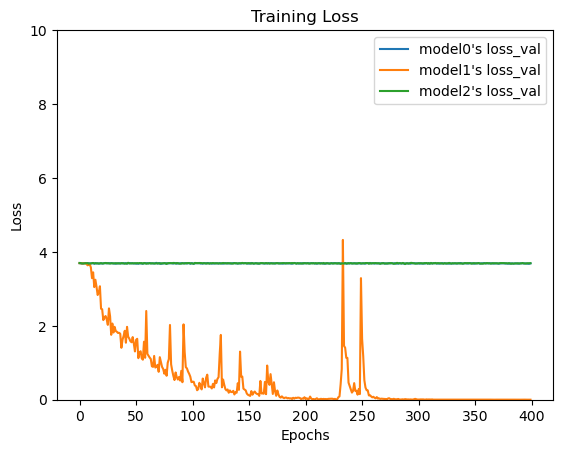

In [936]:
# 模型训练损失可视化
draw_train_hist([loss_val_list1,loss_val_list2,loss_val_list3])


In [937]:
# 模型测试
test_model(train_dl, models[0])
test_model(train_dl, models[1])
test_model(train_dl, models[2])

-----------------------------------
Accuracy: 2.5%
correct=10,total=400
predicted=tensor([24, 24, 24, 24, 24], device='cuda:0')
target=tensor([18, 27, 12,  5, 22])
-----------------------------------
Accuracy: 100.0%
correct=400,total=400
predicted=tensor([22,  2, 13,  9, 31], device='cuda:0')
target=tensor([22,  2, 13,  9, 31])
-----------------------------------
Accuracy: 2.5%
correct=10,total=400
predicted=tensor([10, 10, 10, 10, 10], device='cuda:0')
target=tensor([24, 38, 30, 31, 39])


In [938]:
# 模型保存
# torch.save(models[1], 'model1.pth')
# 模型加载
# models[1].load_state_dict(torch.load('./model1.pth'))
# test_model(train_dl, models[0])